In [4]:
from regain.datasets.hmm import generate_hmm
from regain.hmm.incremental_hmm_graphical_lasso import Incremental_HMM_GraphicalLasso as IncHMM
import numpy as np
from importlib import reload
import regain.hmm.utils; reload(regain.hmm.utils)
from regain.hmm.utils import results_recap#,prepare_data_to_predict
from regain.hmm.utils import cross_validation
from regain.hmm.hmm_graphical_lasso import HMM_GraphicalLasso
import matplotlib.pyplot as plt

/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/federicociech/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
N_samples = 1000
N_states = 5
N_TS = 10
sigma_Normal = 1


In [4]:
Ntrial =8

res_Vmeas_batch = 0
res_MCC_batch = 0

lists_perc_increm = [0.025,0.05,0.075,0.1, 0.15,0.2,0.25,0.3]

res_Vmeas_Inc = np.zeros(len(lists_perc_increm))
res_MCC_Inc = np.zeros(len(lists_perc_increm))

for n in range(Ntrial):


    dataset = generate_hmm(n_samples= N_samples,
                           n_states=N_states,
                           n_dim_obs=N_TS,
                           mode_precisions='regain',
                           mode_mean = 'Normal',
                           transition_type='fixed',
                           sigma=sigma_Normal)

    lambda_GL = 30
    toll = 1e-4
    max_iterations = 100
    reps = 10

        
    # Batch
    
    hmm_gmm = HMM_GraphicalLasso(n_clusters=N_states,
                             alpha=lambda_GL,
                             tol=toll,
                             verbose=False,
                             mode='scaled',
                             warm_restart=True,
                             max_iter=max_iterations,
                             repetitions=reps,
                             n_jobs=-1)
    hmm_gmm.fit(dataset['data'])
    res_batch = results_recap(dataset['states'], hmm_gmm.labels_, dataset['thetas'], hmm_gmm.precisions_, 
                  dataset['gammas'], hmm_gmm.gammas_)
    
    res_Vmeas_batch += res_batch['v_measure [0, 1]']/Ntrial
    res_MCC_batch += res_batch['weighted_mean_mcc [-1, 1]'][0]/Ntrial
    
    
    # Incremental

    for ii,perc_increm in enumerate(lists_perc_increm):
        print(perc_increm)

        mdl = IncHMM(n_clusters=N_states,
                     alpha=lambda_GL,
                     n_for_init=int(N_samples*(1-perc_increm)),
                     max_iter=max_iterations,
                     tol=toll,
                     verbose=False,
                     warm_restart=True,
                     repetitions=reps,
                     n_jobs=-1)
        
        mdl.fit(dataset['data'])
        res_increm = results_recap(dataset['states'], mdl.labels_, dataset['thetas'], mdl.precisions_, 
                      dataset['gammas'], mdl.gammas_)
        
        res_Vmeas_Inc[ii] = res_Vmeas_Inc[ii] + res_increm['v_measure [0, 1]']/Ntrial
        res_MCC_Inc[ii] = res_MCC_Inc[ii] + res_increm['weighted_mean_mcc [-1, 1]'][0]/Ntrial

/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.025


/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.05


/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.075


/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.1


/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.15
0.2


/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.25


/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.3


/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.025


/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.05
0.075


/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.1
0.15


/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.2


/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.25
0.3


/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.025
0.05


/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.075


/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.1


/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.15


/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.2


/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.25


/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.3


/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.025


/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.05


/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.075


/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.1


/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.15
0.2


/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.25


/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.3


/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.025


/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.05


/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.075
0.1


/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.15
0.2


/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.25


/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.3


/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.025
0.05
0.075


/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.1


/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.15


/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.2


/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.25


/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.3


/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.025


/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.05
0.075


/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.1


/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.15
0.2


/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.25
0.3


/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.025


/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.05


/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.075


/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.1


/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.15
0.2


/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.25


/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.3


/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/federicociech/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [5]:
resV_tot = []
resV_tot.append(res_Vmeas_batch)
resV_tot.extend(res_Vmeas_Inc)

In [27]:
resM_tot = []
resM_tot.append(res_MCC_batch)
resM_tot.extend(res_MCC_Inc)

In [28]:
print(resV_tot)

[0.8715194623879042, 0.8230045981922648, 0.7826516501604829, 0.7390240958639888, 0.6988068737112137, 0.6349892808418726, 0.5900320132369163, 0.5351074633529295, 0.48012455718829733]


In [29]:
print(resV_tot/res_Vmeas_batch)

[1.         0.94433301 0.89803118 0.84797199 0.8018259  0.72860023
 0.6770153  0.6139937  0.55090515]


In [30]:
print(resM_tot/res_MCC_batch)

[1.         0.62529486 0.59629171 0.49095059 0.46116774 0.45659039
 0.40027865 0.37638853 0.34252487]


In [31]:
list_a = [1-i for i in [0,0.025,0.05,0.075,0.1, 0.15,0.2,0.25,0.3]]

In [34]:
import pickle as pkl
with open('IncBatch.pickle', 'wb') as f:
    pkl.dump([list_a,resM_tot,res_MCC_batch,resV_tot,res_Vmeas_batch], f)

Text(0,0.5,'MCC_inc/MCC_batch')

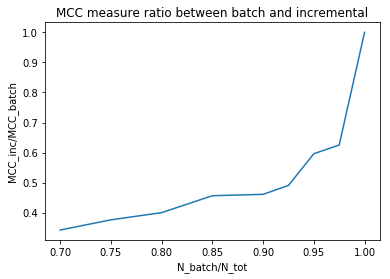

In [6]:
plt.plot(list_a,resM_tot/res_MCC_batch)
plt.title('MCC measure ratio between batch and incremental')
plt.xlabel('N_batch/N_tot')
plt.ylabel('MCC_inc/MCC_batch')

Text(0,0.5,'VMeas_inc/VMeas_batch')

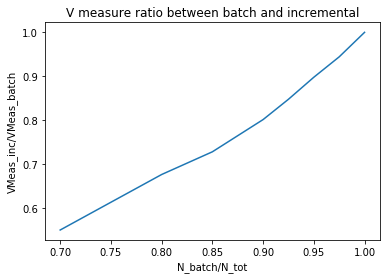

In [5]:
plt.plot(list_a,resV_tot/res_Vmeas_batch)
plt.title('V measure ratio between batch and incremental')
plt.xlabel('N_batch/N_tot')
plt.ylabel('VMeas_inc/VMeas_batch')

In [2]:
import pickle 
with open('IncBatch.pickle', 'rb') as f:
    [list_a,resM_tot,res_MCC_batch,resV_tot,res_Vmeas_batch] =  pickle.load(f)
